LightGBM


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib
import lightgbm as lgb


# Create a dictionary to store data for each horizon
test_data = {}
horizons = [1, 5, 21]

# Load test data for each horizon
for horizon in horizons:
    # Define the file path
    file_path = f'C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_results_h{horizon}.csv'
    
    # Load the data and store it in the dictionary
    test_data[horizon] = pd.read_csv(file_path)
    
    # Print confirmation and info about the loaded data
    print(f"Loaded test_data_h{horizon}: {test_data[horizon].shape}")
    print(f"Columns: {test_data[horizon].columns.tolist()[:10]}...")  # First 10 columns
    print("-" * 50)

# Extract option-only features for each horizon
option_columns = [
    'cp_flag',
    'stock_price',
    'moneyness',
    'time_to_expiry',
    'strike_price',
    'rf',
    'delta',
    'gamma',
    'vega',
    'theta',
    'iv_ahbs',
    'iv_ahbs_error',
    'iv_bs',
    'iv_bs_error',
    'iv_cw',
    'iv_cw_error',
    'impl_volatility'
]


train_data = pd.read_csv('C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_results_train.csv')
# Drop the date column
train_data = train_data.drop(columns=['date', 'moneyness_category'])
train_data = train_data
print(f"\nTrain data:")
print(f"Shape: {train_data.shape}")

Loaded test_data_h1: (2571058, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------
Loaded test_data_h5: (2203398, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------
Loaded test_data_h21: (1341910, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------

Train data:
Shape: (2669654, 166)


In [2]:
###########################################
# PART 1: LIGHTGBM MODEL DEFINITION
###########################################

def create_lgb_model(model_type):

    if model_type == 'LGB1':
        # Standard LightGBM configuration
        params = {
            'objective': 'regression',
            'metric': 'mse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1
        }
    
    elif model_type == 'LGB2':
        # More complex LightGBM configuration with different hyperparameters
        params = {
            'objective': 'regression',
            'metric': 'mse',
            'boosting_type': 'gbdt',
            'num_leaves': 63,
            'learning_rate': 0.01,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.7,
            'bagging_freq': 4,
            'min_data_in_leaf': 20,
            'max_depth': 10,
            'verbose': -1
        }
    
    else:
        raise ValueError("Invalid model type. Choose from 'LGB1' or 'LGB2'.")
    
    return params

def train_and_evaluate_model(params, X_train, y_train, X_test, y_test, num_boost_round=100):

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Train model with early stopping
    model = lgb.train(
        params,
        train_data,
        num_boost_round=num_boost_round,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True)]
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return model, mse

In [3]:
###########################################
# PART 2: DATA PREPARATION
###########################################

import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(option_only, save_paths=True):
    features = joblib.load(r'C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\LigthGBM Forecast\Firm Characteristics\feature_columns.pkl')    

    X_train = option_only[features]
    y_train = {
        'bs': option_only['iv_bs_error'],
        'ahbs': option_only['iv_ahbs_error'],
        'cw': option_only['iv_cw_error']
    }

    # 3) Scale training data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train),
        columns=features
    )

    # 4) Persist artifacts if required
    if save_paths:
        joblib.dump(scaler, 'scaler.pkl')
        joblib.dump(features, 'feature_columns.pkl')

    return X_train_scaled, y_train, scaler, features



In [4]:
###########################################
# PART 3: PREDICTION FUNCTION
###########################################

def predict_and_add_to_test_data(models, test_data, scaler, feature_columns, error_type):

    # Create a copy of the test data to avoid modifying the original
    result_df = test_data.copy()
    
    # Extract features from test data
    X_test = test_data[feature_columns]
    
    # Scale the features using the pre-fitted scaler
    X_test_scaled = scaler.transform(X_test)
    
    # Original value column name
    original_column = f'iv_{error_type}'
    
    # Generate predictions for each model
    for model_name, model in models.items():
        # Make predictions
        predictions = model.predict(X_test_scaled)
        
        # Add predictions to the dataframe
        column_name = f'iv_{error_type}_pred_{model_name}'
        result_df[column_name] = predictions
        
        # Calculate corrected value by adding the error prediction to the original value
        result_df[f'iv_{error_type}_corrected_{model_name}'] = result_df[original_column] + predictions
    
    return result_df

In [5]:
###########################################
# PART 4: FEATURE IMPORTANCE ANALYSIS 
###########################################

#gain split, not used in real thesis
def analyze_feature_importance(model, feature_columns):

    # Get feature importance
    importance = model.feature_importance(importance_type='gain')
    
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    return importance_df


In [ ]:

###########################################
# PART 5: COMPLETE WORKFLOW
###########################################

if __name__ == "__main__":
    # Step 1: Load data
    # Assuming option_only and test_data_h1 are loaded from CSV
    # option_only = pd.read_csv('option_data.csv')
    # test_data_h1 = pd.read_csv('test_data_h1.csv')
    
    # Step 2: Prepare data
    X_train_scaled, X_test_scaled, y_train_dict, y_test_dict, scaler, feature_columns = prepare_data(train_data)
    
    # Step 3: Train models for each target variable
    models = {}
    results = {}
    
    # Dictionary to store all models
    all_models = {
        'bs': {},
        'ahbs': {},
        'cw': {}
    }
    
    # Train models for each error type
    for error_type in ['bs', 'ahbs', 'cw']:
        print(f"\n=== Training models for {error_type} error correction ===")
        
        # Get the appropriate training and test targets
        y_train = y_train_dict[error_type]
        y_test = y_test_dict[error_type]
        
        # Train each model configuration
        for lgb_type in ['LGB1', 'LGB2']:
            model_name = f"{lgb_type}_{error_type}"
            print(f"\nTraining {model_name}...")
            
            # Create model parameters
            params = create_lgb_model(lgb_type)
            
            # Train and evaluate model
            model, mse = train_and_evaluate_model(
                params, X_train_scaled, y_train, X_test_scaled, y_test, num_boost_round=500
            )
            
            # Store model and results
            all_models[error_type][lgb_type] = model
            results[model_name] = {
                'mse': mse,
                'feature_importance': analyze_feature_importance(model, feature_columns)
            }
            
            print(f"{model_name} Test MSE: {mse}")
            
            # Save feature importance
            results[model_name]['feature_importance'].to_csv(f"{model_name}_feature_importance.csv", index=False)
            
            # Save model (using LightGBM's save_model method)
            model.save_model(f"{model_name}_model.txt")



=== Training models for bs error correction ===

Training LGB1_bs...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000607087
LGB1_bs Test MSE: 0.0006070869152973894

Training LGB2_bs...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.00113939
LGB2_bs Test MSE: 0.0011393858032604344

=== Training models for ahbs error correction ===

Training LGB1_ahbs...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000642703
LGB1_ahbs Test MSE: 0.0006427031975518284

Training LGB2_ahbs...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.00106347
LGB2_ahbs Test MSE: 0.0010634703914551495

=== Training models for cw error correction ===

Training LGB1_cw...
Training until v

In [6]:
import os

def load_lgb_models(model_paths_dict):
    loaded_models = {}

    for error_type in model_paths_dict:
        loaded_models[error_type] = {}

        for model_name, path in model_paths_dict[error_type].items():
            try:
                path = path.replace('\\', '/')  # Normalize path
                if not os.path.exists(path):
                    print(f"✗ {error_type} {model_name}: File not found at {path}")
                    loaded_models[error_type][model_name] = None
                    continue

                print(f"Loading {error_type} {model_name}...")
                model = lgb.Booster(model_file=path)
                print(f"✓ Model loaded successfully")

                loaded_models[error_type][model_name] = model

            except Exception as e:
                print(f"✗ Failed to load {error_type} {model_name}: {str(e)}")
                loaded_models[error_type][model_name] = None

    return loaded_models

# Example usage
if __name__ == "__main__":
    # Model paths dictionary with proper path handling for Windows
    # Use forward slashes or raw strings to avoid Unicode escape errors
    model_paths_dict = {
    'bs': {
        'LGB1': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/LigthGBM Forecast/Firm Characteristics/LGB1_bs_model.txt",
        'LGB2': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/LigthGBM Forecast/Firm Characteristics/LGB2_bs_model.txt"
    },
    'ahbs': {
        'LGB1': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/LigthGBM Forecast/Firm Characteristics/LGB1_ahbs_model.txt",
        'LGB2': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/LigthGBM Forecast/Firm Characteristics/LGB2_ahbs_model.txt"
    },
    'cw': {
        'LGB1': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/LigthGBM Forecast/Firm Characteristics/LGB1_cw_model.txt",
        'LGB2': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/LigthGBM Forecast/Firm Characteristics/LGB2_cw_model.txt"
    }
    }

    
    # Load all models
    loaded_models = load_lgb_models(model_paths_dict)
    
    # Print summary of loaded models
    print("\n=== Model Loading Summary ===")
    for error_type in loaded_models:
        for model_name in loaded_models[error_type]:
            status = "✓ Loaded" if loaded_models[error_type][model_name] is not None else "✗ Failed"
            print(f"{error_type} {model_name}: {status}")

Loading bs LGB1...
✓ Model loaded successfully
Loading bs LGB2...
✓ Model loaded successfully
Loading ahbs LGB1...
✓ Model loaded successfully
Loading ahbs LGB2...
✓ Model loaded successfully
Loading cw LGB1...
✓ Model loaded successfully
Loading cw LGB2...
✓ Model loaded successfully

=== Model Loading Summary ===
bs LGB1: ✓ Loaded
bs LGB2: ✓ Loaded
ahbs LGB1: ✓ Loaded
ahbs LGB2: ✓ Loaded
cw LGB1: ✓ Loaded
cw LGB2: ✓ Loaded


In [7]:
test_data_per_horizon = {}

scaler_path = r"C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\LigthGBM Forecast\Firm Characteristics\scaler.pkl"

# Load the scaler
scaler = joblib.load(scaler_path)

for horizon in horizons:
    print(f"\n=== Horizon {horizon} ===")
    
    # 1) Work directly on the base test set
    base_df = test_data[horizon]
    
    # 2) Define features (remove target + metadata columns)
    exclude_cols = [
        'iv_bs_error','iv_ahbs','iv_ahbs_error','iv_bs','iv_cw','iv_cw_error',
        'impl_volatility','moneyness_category','ID','date','new_id',
        'open_interest','option_price','prediction_horizon',
        'test_date','train_date','volume'
    ]
    feature_columns = [c for c in base_df.columns if c not in exclude_cols]

    # Optional: downcast to float32 to reduce memory use
    base_df[feature_columns] = base_df[feature_columns].astype(np.float32)

    # Process corrections for each model type
    for error_type in ['bs', 'ahbs', 'cw']:
        print(f"\n-- Predicting corrections for {error_type.upper()} --")
        
        models_for_type = loaded_models[error_type]  # {'LGB1': model_obj, 'LGB2': model_obj}
        
        # Process predictions in-place without unnecessary full copies
        base_df = predict_and_add_to_test_data(
            models=models_for_type,
            test_data=base_df,
            scaler=scaler,
            feature_columns=feature_columns,
            error_type=error_type
        )
        
        # Preview only essential columns
        preview_cols = ['impl_volatility', f'iv_{error_type}']
        for model in ['LGB1', 'LGB2']:
            preview_cols += [f'iv_{error_type}_pred_{model}', f'iv_{error_type}_corrected_{model}']
        print(base_df[preview_cols].head(3))

    # Store updated DataFrame
    test_data[horizon] = base_df
    print(f"\n✓ option_only_data[{horizon}] updated.")



=== Horizon 1 ===

-- Predicting corrections for BS --
   impl_volatility     iv_bs  iv_bs_pred_LGB1  iv_bs_corrected_LGB1  \
0         0.201081  0.288808        -0.071253              0.217554   
1         0.196421  0.288808        -0.071904              0.216903   
2         0.191262  0.288808        -0.074445              0.214362   

   iv_bs_pred_LGB2  iv_bs_corrected_LGB2  
0        -0.065117              0.223690  
1        -0.067560              0.221248  
2        -0.069543              0.219264  

-- Predicting corrections for AHBS --
   impl_volatility   iv_ahbs  iv_ahbs_pred_LGB1  iv_ahbs_corrected_LGB1  \
0         0.201081  0.299345          -0.061246                0.238099   
1         0.196421  0.298947          -0.065434                0.233513   
2         0.191262  0.298851          -0.066686                0.232165   

   iv_ahbs_pred_LGB2  iv_ahbs_corrected_LGB2  
0          -0.062269                0.237077  
1          -0.063799                0.235148  
2     

C:\Users\maxva\AppData\Local\Temp\ipykernel_21728\2112600467.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsample = test_df.groupby("date").apply(lambda x: x.sample(frac=0.01, random_state=222)).reset_index(drop=True)


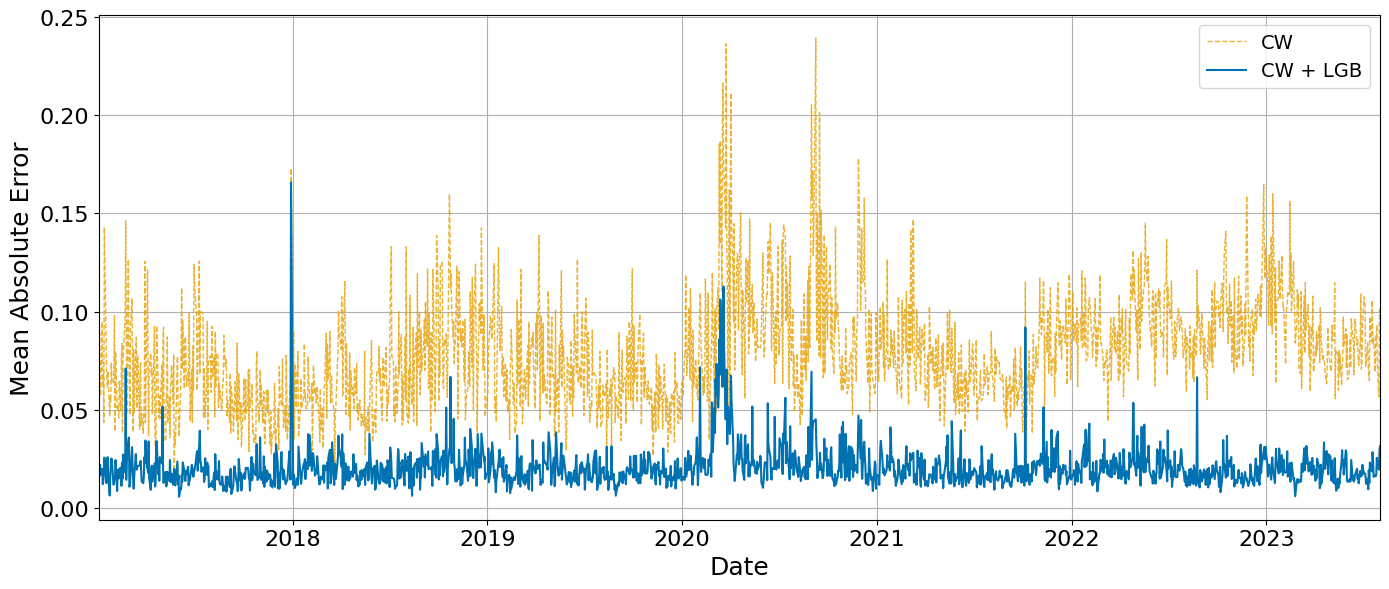

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def compute_and_plot_cw_mae(test_df, horizon_label):
    # Zorg dat 'date' datetime is
    test_df["date"] = pd.to_datetime(test_df["date"])

    # Subsample 1% per date
    subsample = test_df.groupby("date").apply(lambda x: x.sample(frac=0.01, random_state=222)).reset_index(drop=True)

    # Compute absolute errors
    subsample["abs_error_cw_LGB1"] = (subsample["iv_cw_corrected_LGB1"] - subsample["impl_volatility"]).abs()
    subsample["abs_error_cw"] = (subsample["iv_cw"] - subsample["impl_volatility"]).abs()

    # Compute daily average absolute error (MAE)
    daily_mae = subsample.groupby("date")[["abs_error_cw_LGB1", "abs_error_cw"]].mean().reset_index()

    # Plot
    plt.figure(figsize=(14, 6))

    # CW base MAE
    plt.plot(
        daily_mae["date"], daily_mae["abs_error_cw"],
        label="CW", linewidth=1, linestyle='--', color='#E69F00', alpha=0.8
    )

    # CW + LGB MAE
    plt.plot(
        daily_mae["date"], daily_mae["abs_error_cw_LGB1"],
        label="CW + LGB", linewidth=1.5, color='#0072B2'
    )

    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Mean Absolute Error", fontsize=18)

    # Format x-axis to show full date range
    plt.gca().set_xlim(daily_mae["date"].min(), daily_mae["date"].max())

    # Format x-axis ticks
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run for 1-day horizon
compute_and_plot_cw_mae(test_data[1], "1-Day")


Calculate IVRMSE

In [ ]:
import numpy as np

def add_moneyness_categories(df):
    # Create a copy to avoid modifying the original dataframe
    result = df.copy()
    
    # Initialize moneyness_category column explicitly as object dtype
    result['moneyness_category'] = np.nan
    result['moneyness_category'] = result['moneyness_category'].astype('object')
    
    # Define conditions for each category
    dotmc_mask = (result['cp_flag'] == 1) & (result['moneyness'] >= 0.80) & (result['moneyness'] < 0.90)
    otmc_mask = (result['cp_flag'] == 1) & (result['moneyness'] >= 0.90) & (result['moneyness'] < 0.97)
    atm_mask   = (result['moneyness'] >= 0.97) & (result['moneyness'] < 1.03)
    otmp_mask  = (result['cp_flag'] == 0) & (result['moneyness'] >= 1.03) & (result['moneyness'] < 1.10)
    dotmp_mask = (result['cp_flag'] == 0) & (result['moneyness'] >= 1.10) & (result['moneyness'] <= 1.60)
    
    # Assign categories based on conditions
    result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'
    result.loc[otmc_mask, 'moneyness_category'] = 'OTMC'
    result.loc[atm_mask,   'moneyness_category'] = 'ATM'
    result.loc[otmp_mask,  'moneyness_category'] = 'OTMP'
    result.loc[dotmp_mask, 'moneyness_category'] = 'DOTMP'
    
    return result

# Apply the function to each horizon
for horizon in [1, 5, 21]:
    option_only_data[horizon] = add_moneyness_categories(option_only_data[horizon])
    print(f"✓ Added moneyness categories to option_only_data for horizon {horizon}")
    
    display_columns = ['cp_flag', 'moneyness', 'moneyness_category']
    print(f"\nSample data for horizon {horizon}:")
    print(option_only_data[horizon][display_columns].head(5))


✓ Added moneyness categories to option_only_data for horizon 1

Sample data for horizon 1:
   cp_flag  moneyness moneyness_category
0        1   0.996078                ATM
1        1   0.987564                ATM
2        1   0.979195                ATM
3        1   0.970966                ATM
4        1   0.962875               OTMC
✓ Added moneyness categories to option_only_data for horizon 5

Sample data for horizon 5:
   cp_flag  moneyness moneyness_category
0        1   0.996078                ATM
1        1   0.987564                ATM
2        1   0.979195                ATM
3        1   0.970966                ATM
4        1   0.962875               OTMC
✓ Added moneyness categories to option_only_data for horizon 21

Sample data for horizon 21:
   cp_flag  moneyness moneyness_category
0        1   0.962875               OTMC
1        1   0.924360               OTMC
2        1   0.888808              DOTMC
3        1   0.855889              DOTMC
4        0   1.155450       

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

moneyness_groups = ['DOTMC', 'OTMC', 'ATM', 'OTMP', 'DOTMP']

def analyze_ivrmse_by_moneyness(test_data):

    # 1. Group the test data by moneyness
    results = {}
    for group in moneyness_groups:
        group_data = test_data[test_data['moneyness_category'] == group]
        
        # Skip if no data in this group
        if len(group_data) == 0:
            print(f"Warning: No data found for moneyness group {group}")
            continue
            
        # Initialize results for this group
        results[group] = {}
        
        # 2. Calculate IVRMSE for each error type and model
        for error_type in ['bs', 'ahbs', 'cw']:
            # Column names
            orig_col = f'iv_{error_type}'
            
            # Skip if column doesn't exist
            if orig_col not in group_data.columns:
                print(f"Warning: Column {orig_col} not found, skipping...")
                continue
                
            # Calculate baseline IVRMSE
            base_rmse = np.sqrt(mean_squared_error(
                group_data['impl_volatility'], 
                group_data[orig_col]
            ))
            
            # Store baseline IVRMSE
            results[group][f"{error_type}_base"] = base_rmse
            
            # Calculate corrected IVRMSE for each model
            for model in ['LGB1', 'LGB2']:
                corrected_col = f'iv_{error_type}_corrected_{model}'
                
                # Skip if column doesn't exist
                if corrected_col not in group_data.columns:
                    print(f"Warning: Column {corrected_col} not found, skipping...")
                    continue
                    
                corrected_rmse = np.sqrt(mean_squared_error(
                    group_data['impl_volatility'], 
                    group_data[corrected_col]
                ))
                
                # Calculate improvement percentage
                improvement = (base_rmse - corrected_rmse) / base_rmse * 100
                
                # Store results
                results[group][f"{error_type}_{model}"] = corrected_rmse
                results[group][f"{error_type}_{model}_improvement"] = improvement
    
    return results

def format_results_table(results):
    # Prepare IVRMSE table data
    ivrmse_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if not key.endswith('improvement'):
                if key.endswith('base'):
                    # Format baseline columns
                    error_type = key.split('_')[0].upper()
                    row[f"{error_type} Base"] = value
                else:
                    # Format model columns
                    parts = key.split('_')
                    error_type = parts[0].upper()
                    model = parts[1]
                    row[f"{error_type} {model}"] = value
        
        ivrmse_data.append(row)
    
    # Prepare improvement percentage table data
    improvement_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if key.endswith('improvement'):
                # Format improvement columns
                parts = key.replace('_improvement', '').split('_')
                error_type = parts[0].upper()
                model = parts[1]
                row[f"{error_type} {model}"] = value
        
        improvement_data.append(row)
    
    # Create DataFrames
    ivrmse_df = pd.DataFrame(ivrmse_data)
    improvement_df = pd.DataFrame(improvement_data)
    
    # Sort columns for better readability
    ivrmse_cols = ['Moneyness Group']
    improvement_cols = ['Moneyness Group']
    
    for et in ['BS', 'AHBS', 'CW']:
        ivrmse_cols.extend([f"{et} Base", f"{et} LGB1", f"{et} LGB2"])
        improvement_cols.extend([f"{et} LGB1", f"{et} LGB2"])
    
    # Reorder columns if they exist
    ivrmse_df = ivrmse_df[[col for col in ivrmse_cols if col in ivrmse_df.columns]]
    improvement_df = improvement_df[[col for col in improvement_cols if col in improvement_df.columns]]
    
    return ivrmse_df, improvement_df

def find_best_models(results):
    best_models = []
    
    for group, group_results in results.items():
        for error_type in ['bs', 'ahbs', 'cw']:
            # Get baseline IVRMSE
            base_key = f"{error_type}_base"
            if base_key not in group_results:
                continue
                
            base_rmse = group_results[base_key]
            
            # Find best model for this error type
            models = [m for m in ['LGB1', 'LGB2'] if f"{error_type}_{m}" in group_results]
            if not models:
                continue
            
            # Find model with lowest IVRMSE    
            best_model = min(models, key=lambda m: group_results[f"{error_type}_{m}"])
            best_rmse = group_results[f"{error_type}_{best_model}"]
            improvement = group_results[f"{error_type}_{best_model}_improvement"]
            
            # Also get the values for the other model for comparison
            other_models = [m for m in models if m != best_model]
            other_model_data = {}
            if other_models:
                other_model = other_models[0]
                other_rmse = group_results[f"{error_type}_{other_model}"]
                other_improvement = group_results[f"{error_type}_{other_model}_improvement"]
                other_model_data = {
                    f'Other Model': other_model,
                    f'Other IVRMSE': other_rmse,
                    f'Other Improvement %': other_improvement
                }
            
            model_data = {
                'Moneyness Group': group,
                'Error Type': error_type.upper(),
                'Best Model': best_model,
                'Base IVRMSE': base_rmse,
                'Best IVRMSE': best_rmse,
                'Improvement %': improvement
            }
            
            # Add other model data if available
            model_data.update(other_model_data)
            
            best_models.append(model_data)
    
    return pd.DataFrame(best_models)

def print_formatted_tables(results):
    """
    Print formatted tables from the analysis results.
    
    Parameters:
    results (dict): Results from analyze_ivrmse_by_moneyness function
    """
    # Format results into DataFrames
    ivrmse_df, improvement_df = format_results_table(results)
    
    # Format IVRMSE table
    pd.set_option('display.float_format', '{:.6f}'.format)
    print("=" * 80)
    print(f"IVRMSE by Moneyness Group (Horizon: {horizon})")
    print("=" * 80)
    print(ivrmse_df.to_string(index=False))
    
    # Format improvement table
    pd.set_option('display.float_format', '{:.2f}%'.format)
    print("\n" + "=" * 80)
    print("Improvement Percentage by Moneyness Group")
    print("=" * 80)
    print(improvement_df.to_string(index=False))
    
    # Find best models
    best_models_df = find_best_models(results)
    
    # Reset float format for mixed table
    pd.set_option('display.float_format', None)
    print("\n" + "=" * 80)
    print("Best Model by Moneyness Group and Error Type")
    print("=" * 80)
    # Format specific columns
    best_models_df['Base IVRMSE'] = best_models_df['Base IVRMSE'].map('{:.6f}'.format)
    best_models_df['Best IVRMSE'] = best_models_df['Best IVRMSE'].map('{:.6f}'.format)
    best_models_df['Improvement %'] = best_models_df['Improvement %'].map('{:.2f}%'.format)
    print(best_models_df.to_string(index=False))
    
    # Summary statistics
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    
    # Count best model occurrences
    model_counts = best_models_df['Best Model'].value_counts()
    print(f"Overall best model distribution: {dict(model_counts)}")
    
    # Average improvement by moneyness group
    print("\nAverage improvement by moneyness group:")
    # Convert percentage strings to numeric values
    best_models_df['Improvement_Numeric'] = pd.to_numeric(best_models_df['Improvement %'].str.rstrip('%'))
    
    # Group and calculate means
    avg_improvement = best_models_df.groupby('Moneyness Group')['Improvement_Numeric'].mean()
    
    # Handle the case where there's only one group (which returns a scalar)
    if isinstance(avg_improvement, pd.Series):
        # Sort if it's a Series with multiple values
        sorted_improvements = avg_improvement.sort_values(ascending=False)
        for group, imp in sorted_improvements.items():
            print(f"  {group}: {imp:.2f}%")
    else:
        # Just print the single value if it's a scalar
        group = best_models_df['Moneyness Group'].iloc[0]
        print(f"  {group}: {avg_improvement:.2f}%")

# Example usage:
results_h1 = analyze_ivrmse_by_moneyness(option_only_data[1])
results_h5 = analyze_ivrmse_by_moneyness(option_only_data[5])
results_h21 = analyze_ivrmse_by_moneyness(option_only_data[21])
print(results_h1)

# To get the results as DataFrames for further analysis:
#ivrmse_df, improvement_df = format_results_table(results)
#best_models_df = find_best_models(results)

{'DOTMC': {'bs_base': np.float64(0.12766750645454028), 'bs_LGB1': np.float64(0.033629626515844536), 'bs_LGB1_improvement': np.float64(73.65842926694951), 'bs_LGB2': np.float64(0.04194899822671321), 'bs_LGB2_improvement': np.float64(67.14199298499625), 'ahbs_base': np.float64(0.12243300045171161), 'ahbs_LGB1': np.float64(0.03247108724071891), 'ahbs_LGB1_improvement': np.float64(73.47848446013889), 'ahbs_LGB2': np.float64(0.03788588520315571), 'ahbs_LGB2_improvement': np.float64(69.05582231638753), 'cw_base': np.float64(0.11351418965472203), 'cw_LGB1': np.float64(0.03175167411627699), 'cw_LGB1_improvement': np.float64(72.02845370005585), 'cw_LGB2': np.float64(0.03521977963124069), 'cw_LGB2_improvement': np.float64(68.97323608760342)}, 'OTMC': {'bs_base': np.float64(0.11784078504428586), 'bs_LGB1': np.float64(0.027622736679552305), 'bs_LGB1_improvement': np.float64(76.55927303168306), 'bs_LGB2': np.float64(0.033963380570327086), 'bs_LGB2_improvement': np.float64(71.17858595598861), 'ahbs_

In [ ]:

def calculate_ivrmse(predictions_df, error_types=['bs', 'ahbs', 'cw'], models=['LGB1', 'LGB2']):

    results = {}
    
    # Calculate IVRMSE for each error type and model
    for error_type in error_types:
        orig_col = f'iv_{error_type}'
        
        # Calculate base IVRMSE (before correction)
        base_rmse = np.sqrt(mean_squared_error(predictions_df['impl_volatility'], predictions_df[orig_col]))
        results[f"{error_type}_base"] = base_rmse
        
        # Calculate IVRMSE for each model
        for model in models:
            corrected_col = f'iv_{error_type}_corrected_{model}'
            
            # Skip if corrected column doesn't exist
            if corrected_col not in predictions_df.columns:
                print(f"Warning: {corrected_col} column not found, skipping...")
                continue
                
            # Calculate IVRMSE for the corrected predictions
            corrected_rmse = np.sqrt(mean_squared_error(predictions_df['impl_volatility'], predictions_df[corrected_col]))
            results[f"{error_type}_{model}"] = corrected_rmse
            
            # Calculate improvement percentage
            improvement = (base_rmse - corrected_rmse) / base_rmse * 100
            results[f"{error_type}_{model}_improvement"] = improvement
    
    return results
for horizon in horizons:
# Example usage
    if __name__ == "__main__":
        # Calculate IVRMSE
        ivrmse_results = calculate_ivrmse(option_only_data[horizon])
        
        # Print results in a table format
        print(f"\n=== IVRMSE Results === Horizon {horizon} ===")
        print(f"{'Model':<15} {'IVRMSE':<10} {'Improvement':<12}")
        print("-" * 40)
        
        for error_type in ['bs', 'ahbs', 'cw']:
            base_key = f"{error_type}_base"
            if base_key in ivrmse_results:
                base_rmse = ivrmse_results[base_key]
                print(f"{error_type.upper():<15} {base_rmse:.6f}  {'(baseline)':<12}")
                
                for model in ['LGB1', 'LGB2']:
                    model_key = f"{error_type}_{model}"
                    imp_key = f"{error_type}_{model}_improvement"
                    
                    if model_key in ivrmse_results:
                        print(f"{model_key:<15} {ivrmse_results[model_key]:.6f}  {ivrmse_results[imp_key]:.2f}%")
                print("-" * 40)
        
        # Find best overall model
        model_keys = [k for k in ivrmse_results.keys() if not k.endswith('base') and not k.endswith('improvement')]
        if model_keys:
            best_model = min(model_keys, key=lambda k: ivrmse_results[k])
            print(f"\nBest overall model: {best_model} with IVRMSE = {ivrmse_results[best_model]:.6f}")
            
            base_key = f"{best_model.split('_')[0]}_base"
            imp_key = f"{best_model}_improvement"
            if base_key in ivrmse_results and imp_key in ivrmse_results:
                print(f"Improvement over baseline: {ivrmse_results[imp_key]:.2f}%")
                
        # Export results to CSV for further analysis
        results_df = pd.DataFrame({
            'Model': list(ivrmse_results.keys()),
            'Value': list(ivrmse_results.values())
        })



=== IVRMSE Results === Horizon 1 ===
Model           IVRMSE     Improvement 
----------------------------------------
BS              0.130376  (baseline)  
bs_LGB1         0.029951  77.03%
bs_LGB2         0.036783  71.79%
----------------------------------------
AHBS            0.113431  (baseline)  
ahbs_LGB1       0.030422  73.18%
ahbs_LGB2       0.035737  68.49%
----------------------------------------
CW              0.109746  (baseline)  
cw_LGB1         0.030102  72.57%
cw_LGB2         0.034712  68.37%
----------------------------------------

Best overall model: bs_LGB1 with IVRMSE = 0.029951
Improvement over baseline: 77.03%

=== IVRMSE Results === Horizon 5 ===
Model           IVRMSE     Improvement 
----------------------------------------
BS              0.131012  (baseline)  
bs_LGB1         0.043308  66.94%
bs_LGB2         0.046388  64.59%
----------------------------------------
AHBS            0.114337  (baseline)  
ahbs_LGB1       0.043130  62.28%
ahbs_LGB2       0.04

In [ ]:

# Define the moneyness groups
moneyness_groups = ['DOTMC', 'OTMC', 'ATM', 'OTMP', 'DOTMP']

def analyze_ivrmse_by_moneyness(test_data):

    # 1. Group the test data by moneyness
    results = {}
    for group in moneyness_groups:
        group_data = test_data[test_data['moneyness_category'] == group]
        
        # Skip if no data in this group
        if len(group_data) == 0:
            print(f"Warning: No data found for moneyness group {group}")
            continue
            
        # Initialize results for this group
        results[group] = {}
        
        # 2. Calculate IVRMSE for each error type and model
        for error_type in ['bs', 'ahbs', 'cw']:
            # Column names
            orig_col = f'iv_{error_type}'
            
            # Skip if column doesn't exist
            if orig_col not in group_data.columns:
                print(f"Warning: Column {orig_col} not found, skipping...")
                continue
                
            # Calculate baseline IVRMSE
            base_rmse = np.sqrt(mean_squared_error(
                group_data['impl_volatility'], 
                group_data[orig_col]
            ))
            
            # Store baseline IVRMSE
            results[group][f"{error_type}_base"] = base_rmse
            
            # Calculate corrected IVRMSE for each model
            for model in ['LGB1', 'LGB2']:
                corrected_col = f'iv_{error_type}_corrected_{model}'
                
                # Skip if column doesn't exist
                if corrected_col not in group_data.columns:
                    print(f"Warning: Column {corrected_col} not found, skipping...")
                    continue
                    
                corrected_rmse = np.sqrt(mean_squared_error(
                    group_data['impl_volatility'], 
                    group_data[corrected_col]
                ))
                
                # Calculate improvement percentage
                improvement = (base_rmse - corrected_rmse) / base_rmse * 100
                
                # Store results
                results[group][f"{error_type}_{model}"] = corrected_rmse
                results[group][f"{error_type}_{model}_improvement"] = improvement
    
    return results

def format_results_table(results):

    # Prepare IVRMSE table data
    ivrmse_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if not key.endswith('improvement'):
                if key.endswith('base'):
                    # Format baseline columns
                    error_type = key.split('_')[0].upper()
                    row[f"{error_type} Base"] = value
                else:
                    # Format model columns
                    parts = key.split('_')
                    error_type = parts[0].upper()
                    model = parts[1]
                    row[f"{error_type} {model}"] = value
        
        ivrmse_data.append(row)
    
    # Prepare improvement percentage table data
    improvement_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if key.endswith('improvement'):
                # Format improvement columns
                parts = key.replace('_improvement', '').split('_')
                error_type = parts[0].upper()
                model = parts[1]
                row[f"{error_type} {model}"] = value
        
        improvement_data.append(row)
    
    # Create DataFrames
    ivrmse_df = pd.DataFrame(ivrmse_data)
    improvement_df = pd.DataFrame(improvement_data)
    
    # Sort columns for better readability
    ivrmse_cols = ['Moneyness Group']
    improvement_cols = ['Moneyness Group']
    
    for et in ['BS', 'AHBS', 'CW']:
        ivrmse_cols.extend([f"{et} Base", f"{et} LGB1", f"{et} LGB2"])
        improvement_cols.extend([f"{et} LGB1", f"{et} LGB2"])
    
    # Reorder columns if they exist
    ivrmse_df = ivrmse_df[[col for col in ivrmse_cols if col in ivrmse_df.columns]]
    improvement_df = improvement_df[[col for col in improvement_cols if col in improvement_df.columns]]
    
    return ivrmse_df, improvement_df

def find_best_models(results):

    best_models = []
    
    for group, group_results in results.items():
        for error_type in ['bs', 'ahbs', 'cw']:
            # Get baseline IVRMSE
            base_key = f"{error_type}_base"
            if base_key not in group_results:
                continue
                
            base_rmse = group_results[base_key]
            
            # Find best model for this error type
            models = [m for m in ['LGB1', 'LGB2'] if f"{error_type}_{m}" in group_results]
            if not models:
                continue
            
            # Find model with lowest IVRMSE    
            best_model = min(models, key=lambda m: group_results[f"{error_type}_{m}"])
            best_rmse = group_results[f"{error_type}_{best_model}"]
            improvement = group_results[f"{error_type}_{best_model}_improvement"]
            
            # Also get the values for the other model for comparison
            other_models = [m for m in models if m != best_model]
            other_model_data = {}
            if other_models:
                other_model = other_models[0]
                other_rmse = group_results[f"{error_type}_{other_model}"]
                other_improvement = group_results[f"{error_type}_{other_model}_improvement"]
                other_model_data = {
                    f'Other Model': other_model,
                    f'Other IVRMSE': other_rmse,
                    f'Other Improvement %': other_improvement
                }
            
            model_data = {
                'Moneyness Group': group,
                'Error Type': error_type.upper(),
                'Best Model': best_model,
                'Base IVRMSE': base_rmse,
                'Best IVRMSE': best_rmse,
                'Improvement %': improvement
            }
            
            # Add other model data if available
            model_data.update(other_model_data)
            
            best_models.append(model_data)
    
    return pd.DataFrame(best_models)

def print_formatted_tables(results, horizon):

    # Format results into DataFrames
    ivrmse_df, improvement_df = format_results_table(results)

    # Format IVRMSE table
    pd.set_option('display.float_format', '{:.6f}'.format)
    print("=" * 80)
    print(f"IVRMSE by Moneyness Group (Horizon: {horizon})")
    print("=" * 80)
    print(ivrmse_df.to_string(index=False))
    
    # Format improvement table
    pd.set_option('display.float_format', '{:.2f}%'.format)
    print("\n" + "=" * 80)
    print("Improvement Percentage by Moneyness Group")
    print("=" * 80)
    print(improvement_df.to_string(index=False))
    
    # Find best models
    best_models_df = find_best_models(results)
    
    # Reset float format for mixed table
    pd.set_option('display.float_format', None)
    print("\n" + "=" * 80)
    print("Best Model by Moneyness Group and Error Type")
    print("=" * 80)
    # Format specific columns
    best_models_df['Base IVRMSE'] = best_models_df['Base IVRMSE'].map('{:.6f}'.format)
    best_models_df['Best IVRMSE'] = best_models_df['Best IVRMSE'].map('{:.6f}'.format)
    best_models_df['Improvement %'] = best_models_df['Improvement %'].map('{:.2f}%'.format)
    print(best_models_df.to_string(index=False))
    
    # Summary statistics
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    
    # Count best model occurrences
    model_counts = best_models_df['Best Model'].value_counts()
    print(f"Overall best model distribution: {dict(model_counts)}")
    
    # Average improvement by moneyness group
    print("\nAverage improvement by moneyness group:")
    # Convert percentage strings to numeric values
    best_models_df['Improvement_Numeric'] = pd.to_numeric(best_models_df['Improvement %'].str.rstrip('%'))
    
    # Group and calculate means
    avg_improvement = best_models_df.groupby('Moneyness Group')['Improvement_Numeric'].mean()
    
    # Handle the case where there's only one group (which returns a scalar)
    if isinstance(avg_improvement, pd.Series):
        # Sort if it's a Series with multiple values
        sorted_improvements = avg_improvement.sort_values(ascending=False)
        for group, imp in sorted_improvements.items():
            print(f"  {group}: {imp:.2f}%")
    else:
        # Just print the single value if it's a scalar
        group = best_models_df['Moneyness Group'].iloc[0]
        print(f"  {group}: {avg_improvement:.2f}%")
    
    # Save results to CSV files
    ivrmse_df.to_csv('ivrmse_by_moneyness_lightgbm.csv', index=False)
    improvement_df.to_csv('improvement_by_moneyness_lightgbm.csv', index=False)
    best_models_df.to_csv('best_models_by_moneyness_lightgbm.csv', index=False)

all_results = {
    1: analyze_ivrmse_by_moneyness(option_only_data[1]),
    5: analyze_ivrmse_by_moneyness(option_only_data[5]),
    21: analyze_ivrmse_by_moneyness(option_only_data[21])
}

for h, res in all_results.items():
    print_formatted_tables(res, h)

IVRMSE by Moneyness Group (Horizon: 1)
Moneyness Group  BS Base  BS LGB1  BS LGB2  AHBS Base  AHBS LGB1  AHBS LGB2  CW Base  CW LGB1  CW LGB2
          DOTMC 0.127668 0.033630 0.041949   0.122433   0.032471   0.037886 0.113514 0.031752 0.035220
           OTMC 0.117841 0.027623 0.033963   0.110103   0.027157   0.032606 0.108715 0.026534 0.031656
            ATM 0.115332 0.026715 0.033213   0.110987   0.027084   0.033160 0.108876 0.027084 0.033276
           OTMP 0.108485 0.027148 0.033295   0.106252   0.027347   0.032457 0.105232 0.027196 0.032030
          DOTMP 0.169017 0.034356 0.041374   0.117603   0.036983   0.041767 0.112094 0.036823 0.040435

Improvement Percentage by Moneyness Group
Moneyness Group  BS LGB1  BS LGB2  AHBS LGB1  AHBS LGB2  CW LGB1  CW LGB2
          DOTMC   73.66%   67.14%     73.48%     69.06%   72.03%   68.97%
           OTMC   76.56%   71.18%     75.34%     70.39%   75.59%   70.88%
            ATM   76.84%   71.20%     75.60%     70.12%   75.12%   69.44%
    

Feature Importance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_and_plot_feature_importance(model, feature_columns, model_name='Model', importance_type='gain'):

    # Get feature importance
    importance = model.feature_importance(importance_type=importance_type)
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.gca().invert_yaxis()  # Highest on top
    title_type = 'Gain-based' if importance_type == 'gain' else 'Split-based'
    plt.title(f'{model_name} {title_type} Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return importance_df


In [ ]:
sample_df = test_data[1].sample(n=500000, random_state=42)

Processing bs LGB1


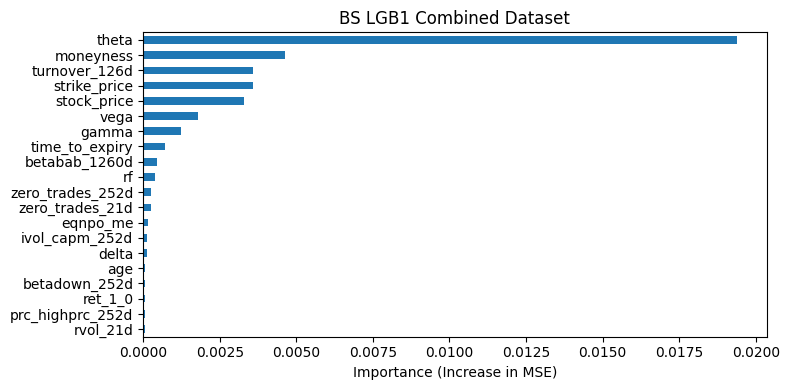

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def manual_permutation_importance(model, X: np.ndarray, y: np.ndarray,
                                  feature_names: list[str],
                                  n_repeats: int = 10,
                                  random_state: int = 42) -> pd.Series:
    rng = np.random.RandomState(random_state)
    baseline_preds = model.predict(X, verbose=0).flatten()
    baseline_score = mean_squared_error(y, baseline_preds)

    importances = []
    for idx, col in enumerate(feature_names):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[:, idx] = rng.permutation(X_permuted[:, idx])
            permuted_preds = model.predict(X_permuted, verbose=0).flatten()
            score = mean_squared_error(y, permuted_preds)
            scores.append(score - baseline_score)
        importances.append(np.mean(scores))

    return pd.Series(importances, index=feature_names).sort_values(ascending=False)

def plot_importance(importance: pd.Series, top_n: int = 20, title: str = "Feature Importance"):
    data = importance.head(top_n).sort_values()
    plt.figure(figsize=(8, max(4, 0.2 * top_n)))
    data.plot.barh()
    plt.xlabel('Importance (Increase in MSE)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

X_test_scaled, y_test_dict, _, _ = prepare_data(sample_df, save_paths=False)

# Load feature columns
feature_columns = joblib.load(r'C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\LigthGBM Forecast\Firm Characteristics\feature_columns.pkl')

# Safely access only BS -> LGB1
error_type = 'bs'
model_name = 'LGB1'

# Get the model
model = loaded_models.get(error_type, {}).get(model_name, None)

if model is None:
    print(f"Skipping {error_type} {model_name}: model not loaded")
else:
    print(f"Processing {error_type} {model_name}")

    # Select the correct y target
    y_test = y_test_dict[error_type]

    # Compute permutation importance
    imp_perm = manual_permutation_importance(model, X_test_scaled.values, y_test.values, feature_columns)

    # Plot the results
    title = f"{error_type.upper()} {model_name} Combined Dataset"
    plot_importance(imp_perm, top_n=20, title=title)